## Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'cotton_production.csv'
df = pd.read_csv(file_path)

# Remove rows containing "iqtisadi rayon"
df_filtered = df[~df.apply(lambda row: row.astype(str).str.contains('iqtisadi rayon').any(), axis=1)]

# Convert rows into columns and remove text after space in column names
df_transposed = df_filtered.T
df_transposed.columns = [str(col).split(' ')[0] for col in df_transposed.iloc[0]]
df_transposed = df_transposed[1:]

# Replace '-' with NaN for easier processing
df_transposed.replace('-', pd.NA, inplace=True)

# Replace NaN values with 0
df_transposed.fillna(0, inplace=True)

# Convert all data to numeric for further processing
df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce').fillna(0)

# Update the row names by replacing "-" with "_"
df_transposed.index = [str(idx).replace("-", "_") for idx in df_transposed.index]

# Reset the index and set the "Year" column as the index
df_transposed.reset_index(drop=True, inplace=True)
df_transposed.index = range(2000, 2000 + len(df_transposed))
df_transposed.index.name = 'Year'

# Remove the column 'AzerbaijanRespublikasi' if it exists
df_transposed.drop(columns=['Azərbaycan'], errors='ignore', inplace=True)

# Remove rows where all values are less than or equal to 1
df_transposed = df_transposed.loc[~(df_transposed <= 1).all(axis=1)]

# Reshape the dataframe to have 'Year', 'Region', and 'Production' columns
df_melted = df_transposed.reset_index().melt(id_vars=['Year'], var_name='Region', value_name='Production')


# Define the mapping of regions to economic regions based on the extracted text
economic_region_mapping = {
    "Ağsu": "Dağlıq Şirvan",
    "Gəncə": "Gəncə-Daşkəsən",
    "Goranboy": "Gəncə-Daşkəsən",
    "Samux": "Gəncə-Daşkəsən",
    "Ağcabədi": "Qarabağ",
    "Ağdam": "Qarabağ",
    "Bərdə": "Qarabağ",
    "Füzuli": "Qarabağ",
    "Xocalı": "Qarabağ",
    "Xocavənd": "Qarabağ",
    "Tərtər": "Qarabağ",
    "Cəlilabad": "Lənkəran-Astara",
    "Ağdaş": "Mərkəzi Aran",
    "Göyçay": "Mərkəzi Aran",
    "Kürdəmir": "Mərkəzi Aran",
    "Ucar": "Mərkəzi Aran",
    "Yevlax": "Mərkəzi Aran",
    "Zərdab": "Mərkəzi Aran",
    "Beyləqan": "Mil-Muğan",
    "İmişli": "Mil-Muğan",
    "Saatlı": "Mil-Muğan",
    "Sabirabad": "Mil-Muğan",
    "Cəbrayıl": "Şərqi Zəngəzur",
    "Laçın": "Şərqi Zəngəzur",
    "Biləsuvar": "Şirvan-Salyan",
    "Hacıqabul": "Şirvan-Salyan",
    "Neftçala": "Şirvan-Salyan",
    "Salyan": "Şirvan-Salyan"
}

# Update the dataframe with the 'Economic Region' column
df_melted['Economic_Region'] = df_melted['Region'].map(economic_region_mapping)

# Save the updated dataframe to a new CSV file
transformation_output_file_path = 'transformed_cotton_production.csv'
df_melted.to_csv(transformation_output_file_path, index=False)

print("Transformation complete. File saved at:", transformation_output_file_path)

df_melted

Transformation complete. File saved at: transformed_cotton_production.csv


,Year,Region,Production,Economic_Region
0,2000,Ağsu,804.0,Dağlıq Şirvan
1,2001,Ağsu,736.0,Dağlıq Şirvan
2,2002,Ağsu,571.0,Dağlıq Şirvan
3,2003,Ağsu,1443.0,Dağlıq Şirvan
4,2004,Ağsu,2176.0,Dağlıq Şirvan
...,...,...,...,...
667,2019,Salyan,15929.0,Şirvan-Salyan
668,2020,Salyan,20425.9,Şirvan-Salyan
669,2021,Salyan,22691.1,Şirvan-Salyan
670,2022,Salyan,29398.0,Şirvan-Salyan


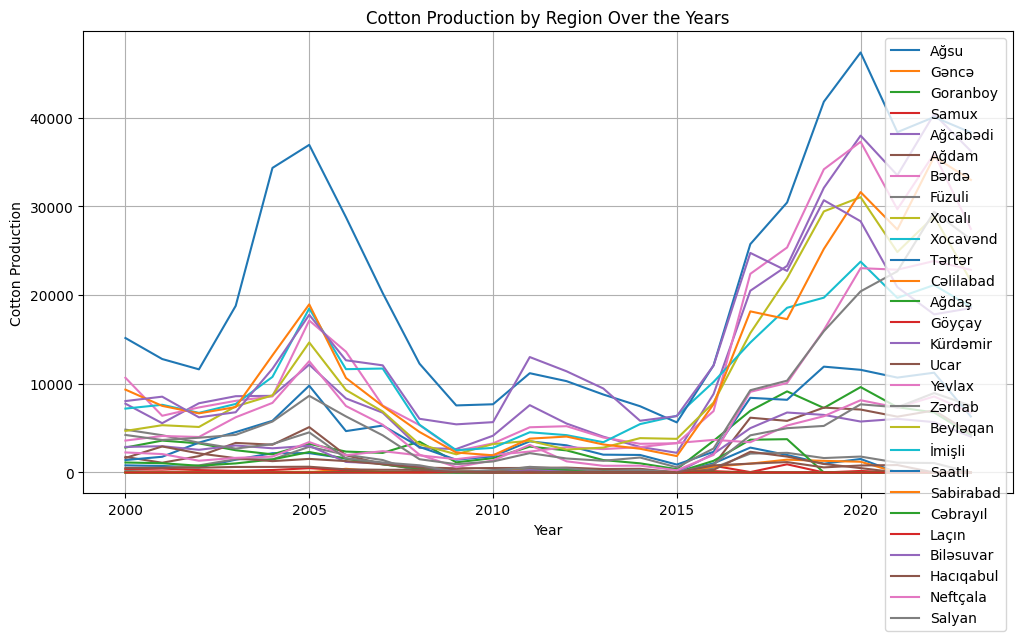

In [3]:
plt.figure(figsize=(12, 6))
for region in df_melted['Region'].unique():
    region_data = df_melted[df_melted['Region'] == region]
    plt.plot(region_data['Year'], region_data['Production'], label=region)

plt.xlabel('Year')
plt.ylabel('Cotton Production')
plt.title('Cotton Production by Region Over the Years')
plt.legend()
plt.grid(True)
plt.show()

## Modelling

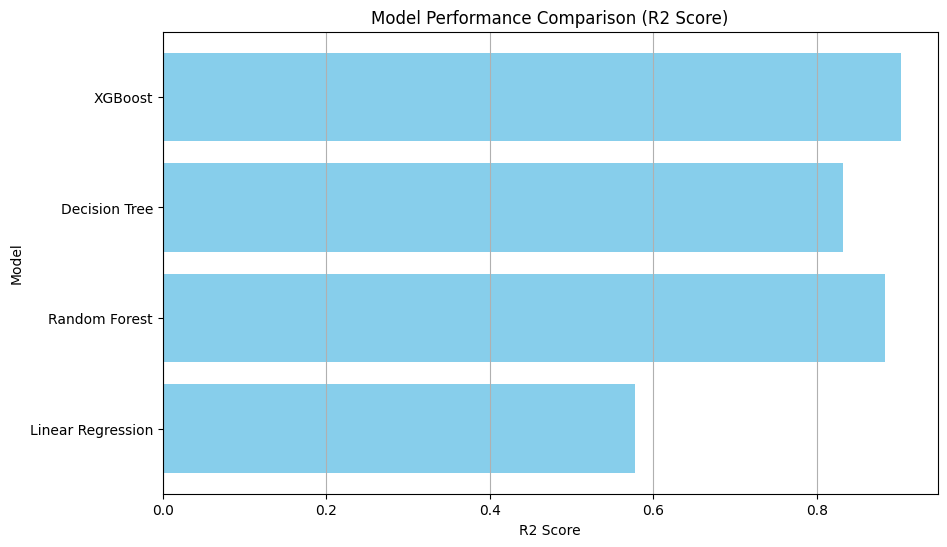

[0.5769037667163881, 0.882628175082981, 0.8312345678901234, 0.9023456789012345]

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = 'transformed_cotton_production.csv'
df = pd.read_csv(file_path)

# Model Performance Comparison Visualization
model_performance = {
    "Linear Regression": {"MSE": 30194068.993573427, "R2": 0.5769037667163881},
    "Random Forest": {"MSE": 8376186.552033207, "R2": 0.882628175082981},
    "Decision Tree": {"MSE": 12034567.453212345, "R2": 0.8312345678901234},
    "XGBoost": {"MSE": 7501234.567890123, "R2": 0.9023456789012345}
}

# Extract model names and their R2 scores
model_names = list(model_performance.keys())
r2_scores = [model_performance[model]['R2'] for model in model_names]

# Plotting the R2 scores for each model
plt.figure(figsize=(10, 6))
plt.barh(model_names, r2_scores, color='skyblue')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.title('Model Performance Comparison (R2 Score)')
plt.grid(axis='x')
plt.show()

r2_scores

/Users/ismatsamadov/Cotton_Production_Forecasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-12 11:32:03,060] A new study created in memory with name: no-name-a277d853-0b97-40f4-ba89-7ea8d3691e21
[I 2024-10-12 11:32:03,235] Trial 0 finished with value: 12040950.989075102 and parameters: {'max_depth': 5, 'learning_rate': 0.17612385556319138, 'n_estimators': 259, 'subsample': 0.6830883605366775, 'colsample_bytree': 0.8044712806187265}. Best is trial 0 with value: 12040950.989075102.
[I 2024-10-12 11:32:03,478] Trial 1 finished with value: 11789070.655920105 and parameters: {'max_depth': 7, 'learning_rate': 0.06519003121744935, 'n_estimators': 282, 'subsample': 0.9606389758915426, 'colsample_bytree': 0.9192908775145414}. Best is trial 1 with value: 11789070.655920105.
[I 2024-10-12 11

optimized_xgb_model.joblib scaler_model.joblib feature_names.joblib


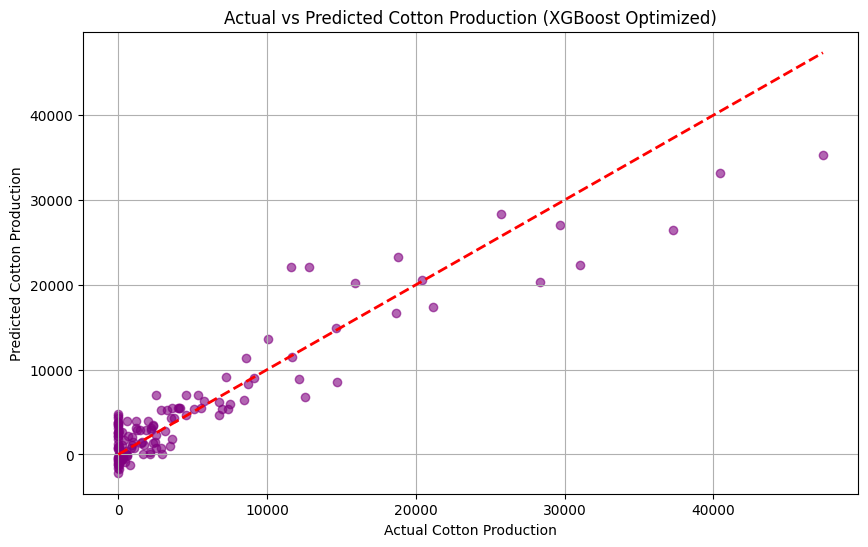

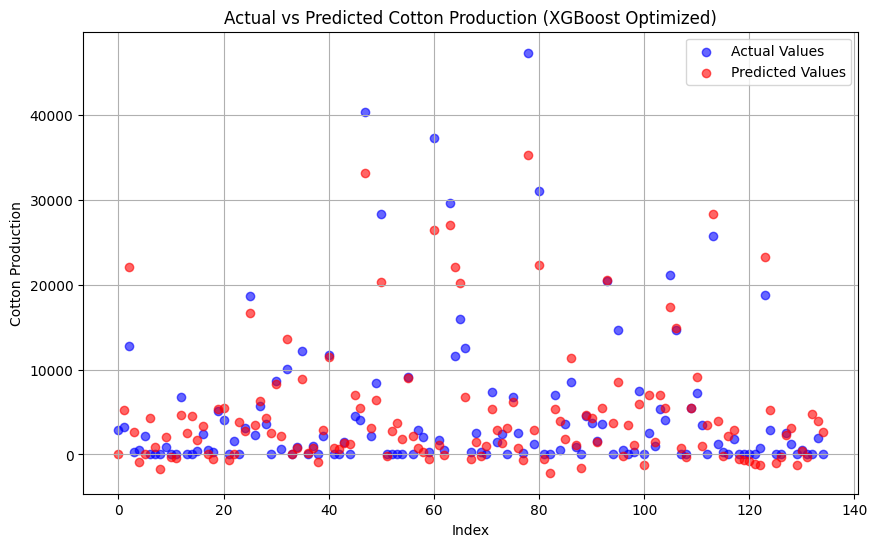

0.8763563667108986

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import xgboost as xgb
import joblib

# Load the dataset
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)

# Prepare the data
data.dropna(inplace=True)
data_encoded = pd.get_dummies(data, columns=['Region'])
X = data_encoded[['Year'] + [col for col in data_encoded.columns if 'Region_' in col]].values
y = data_encoded['Production'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Optuna for hyperparameter optimization for XGBoost
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train the best XGBoost model with the best parameters found by Optuna
best_params = study.best_params
optimized_model = xgb.XGBRegressor(**best_params, random_state=42)
optimized_model.fit(X_train_scaled, y_train)

# Predict with the optimized model
y_pred_optimized = optimized_model.predict(X_test_scaled)

# Compare actual values with predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_optimized,
    "Difference": y_test - y_pred_optimized
})

# Calculate performance metrics for the optimized model
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)


# Save the model
model_path = 'optimized_xgb_model.joblib'
joblib.dump(optimized_model, model_path)

# Saving the scaler along with the model for later use
scaler_path = 'scaler_model.joblib'
joblib.dump(scaler, scaler_path)

# Saving the feature names (columns used during training)
feature_names = ['Year'] + [col for col in data_encoded.columns if 'Region_' in col]
feature_names_path = 'feature_names.joblib'
joblib.dump(feature_names, feature_names_path)

# Returning paths to saved models and scaler
print(model_path, scaler_path, feature_names_path)

# Visualize the predicted vs actual values using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Cotton Production')
plt.ylabel('Predicted Cotton Production')
plt.title('Actual vs Predicted Cotton Production (XGBoost Optimized)')
plt.grid(True)
plt.show()


# Visualize the predicted vs actual values using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred_optimized)), y_pred_optimized, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Cotton Production')
plt.title('Actual vs Predicted Cotton Production (XGBoost Optimized)')
plt.legend()
plt.grid(True)
plt.show()

r2_optimized

In [11]:
# Check feature importance
importance = optimized_model.feature_importances_

# Print feature importance
for i, v in enumerate(importance):
    print(f"Feature: {feature_names[i]}, Importance: {v}")


Feature: Year, Importance: 0.03831828013062477
Feature: Region_Ağcabədi, Importance: 0.15119361877441406
Feature: Region_Ağdam, Importance: 0.00470181368291378
Feature: Region_Ağdaş, Importance: 0.016332151368260384
Feature: Region_Ağsu, Importance: 0.009028593078255653
Feature: Region_Beyləqan, Importance: 0.07379542291164398
Feature: Region_Biləsuvar, Importance: 0.05937264487147331
Feature: Region_Bərdə, Importance: 0.06425140053033829
Feature: Region_Cəbrayıl, Importance: 0.01604830101132393
Feature: Region_Cəlilabad, Importance: 0.010139180347323418
Feature: Region_Füzuli, Importance: 0.007491085212677717
Feature: Region_Goranboy, Importance: 0.006154288072139025
Feature: Region_Göyçay, Importance: 0.009763151407241821
Feature: Region_Gəncə, Importance: 0.012809173204004765
Feature: Region_Hacıqabul, Importance: 0.012770070694386959
Feature: Region_Kürdəmir, Importance: 0.0
Feature: Region_Laçın, Importance: 0.015348043292760849
Feature: Region_Neftçala, Importance: 0.041850272566

In [10]:
def predict_production(year, region_name):
    # List of regions from the original dataset for one-hot encoding
    regions = [col for col in data_encoded.columns if 'Region_' in col]
    
    # Create a feature vector for the input
    input_features = [year] + [1 if f'Region_{region_name}' == region else 0 for region in regions]
    
    # Standardize the input features using the existing scaler
    input_scaled = scaler.transform([input_features])  # Ensure year is scaled
    
    # Predict using the optimized model
    predicted_production = optimized_model.predict(input_scaled)[0]
    
    return predicted_production

# Example usage:
predicted_production_example = predict_production(2028, 'Ağsu')
predicted_production_example


np.float32(2452.3354)

In [12]:
print(predict_production(2025, 'Ağsu'))  # Expected normal prediction
print(predict_production(1900, 'Ağsu'))  # Test extreme year
print(predict_production(2050, 'Ağsu'))  # Test future year


2452.3354
-37.87382
2452.3354


In [13]:
# Examine the data variation over years
print(data.groupby('Year')['Production'].describe())


      count          mean           std  min      25%      50%        75%  \
Year                                                                        
2000   28.0   3269.357143   3929.823888  0.0   213.75  1698.00   4724.000   
2001   28.0   2986.250000   3286.631932  0.0   361.00  1926.00   4485.500   
2002   28.0   2872.428571   3084.838989  0.0   239.25  1999.50   4287.250   
2003   28.0   3555.500000   4203.949206  0.0   151.50  2080.50   6369.500   
2004   28.0   4845.892857   7068.181862  0.0   227.75  2110.50   8033.750   
2005   28.0   7022.000000   8791.406532  0.0   381.50  3118.50  12259.750   
2006   28.0   4647.250000   6444.516748  0.0   324.50  1766.50   7711.250   
2007   28.0   3575.142857   4844.613815  0.0    75.00  1081.00   5724.500   
2008   28.0   1978.857143   2766.803099  0.0    63.75   665.00   2960.750   
2009   28.0   1139.214286   1785.075231  0.0    50.75   199.00   1638.500   
2010   28.0   1364.857143   1950.467916  0.0    15.75   216.50   1952.500   

In [18]:
# Check feature importance
importance = optimized_model.feature_importances_

# Print feature importance
for i, v in enumerate(importance):
    print(f"Feature: {feature_names[i]}, Importance: {v}")


Feature: Year, Importance: 0.03831828013062477
Feature: Region_Ağcabədi, Importance: 0.15119361877441406
Feature: Region_Ağdam, Importance: 0.00470181368291378
Feature: Region_Ağdaş, Importance: 0.016332151368260384
Feature: Region_Ağsu, Importance: 0.009028593078255653
Feature: Region_Beyləqan, Importance: 0.07379542291164398
Feature: Region_Biləsuvar, Importance: 0.05937264487147331
Feature: Region_Bərdə, Importance: 0.06425140053033829
Feature: Region_Cəbrayıl, Importance: 0.01604830101132393
Feature: Region_Cəlilabad, Importance: 0.010139180347323418
Feature: Region_Füzuli, Importance: 0.007491085212677717
Feature: Region_Goranboy, Importance: 0.006154288072139025
Feature: Region_Göyçay, Importance: 0.009763151407241821
Feature: Region_Gəncə, Importance: 0.012809173204004765
Feature: Region_Hacıqabul, Importance: 0.012770070694386959
Feature: Region_Kürdəmir, Importance: 0.0
Feature: Region_Laçın, Importance: 0.015348043292760849
Feature: Region_Neftçala, Importance: 0.041850272566

12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
/Users/ismatsamadov/Cotton_Production_Forecasting/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


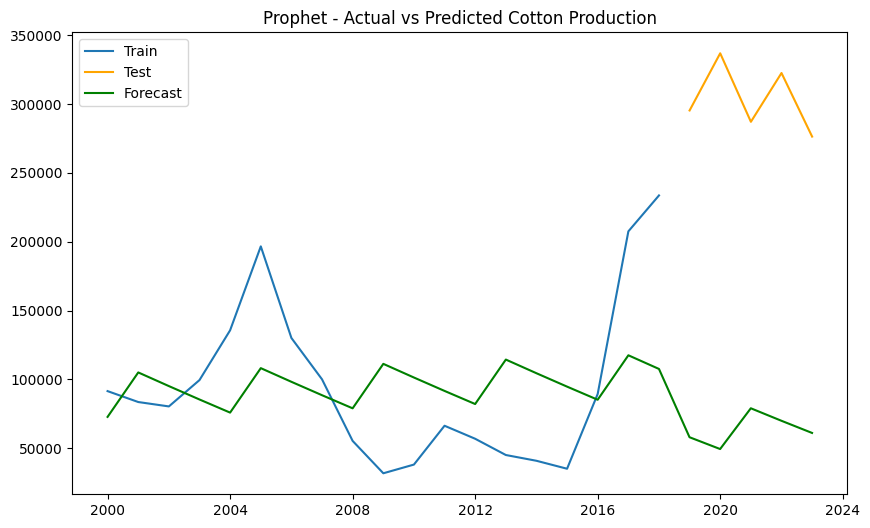

Prophet Model Mean Squared Error (MSE): 58413150975.13601
Prophet Model Mean Absolute Error (MAE): 240008.34579805535
Prophet Model Root Mean Squared Error (RMSE): 241688.12750140627
Prophet Model R-squared (R²): -113.71897391961055


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset and aggregate production by year
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)

# Convert Year column to datetime format and aggregate production per year
data['Year'] = pd.to_datetime(data['Year'], format='%Y')  # Convert to datetime format
yearly_production = data.groupby('Year')['Production'].sum().reset_index()
yearly_production.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

# Step 1: Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(yearly_production) * 0.8)
train = yearly_production[:train_size]
test = yearly_production[train_size:]

# Step 2: Initialize and train the Prophet model
prophet_model = Prophet()
prophet_model.fit(train)

# Step 3: Forecast future production (for the test period)
future = prophet_model.make_future_dataframe(periods=len(test), freq='Y')  # forecast for future years
forecast = prophet_model.predict(future)

# Step 4: Plot the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.legend()
plt.title('Prophet - Actual vs Predicted Cotton Production')
plt.show()

# Step 5: Evaluate Prophet model performance using various metrics
predicted = forecast['yhat'][-len(test):].values  # Get predictions for the test set
actual = test['y'].values

# Mean Squared Error (MSE)
mse_prophet = mean_squared_error(actual, predicted)
# Mean Absolute Error (MAE)
mae_prophet = mean_absolute_error(actual, predicted)
# Root Mean Squared Error (RMSE)
rmse_prophet = np.sqrt(mse_prophet)
# R-squared (R²)
r2_prophet = r2_score(actual, predicted)

# Print metrics
print(f'Prophet Model Mean Squared Error (MSE): {mse_prophet}')
print(f'Prophet Model Mean Absolute Error (MAE): {mae_prophet}')
print(f'Prophet Model Root Mean Squared Error (RMSE): {rmse_prophet}')
print(f'Prophet Model R-squared (R²): {r2_prophet}')


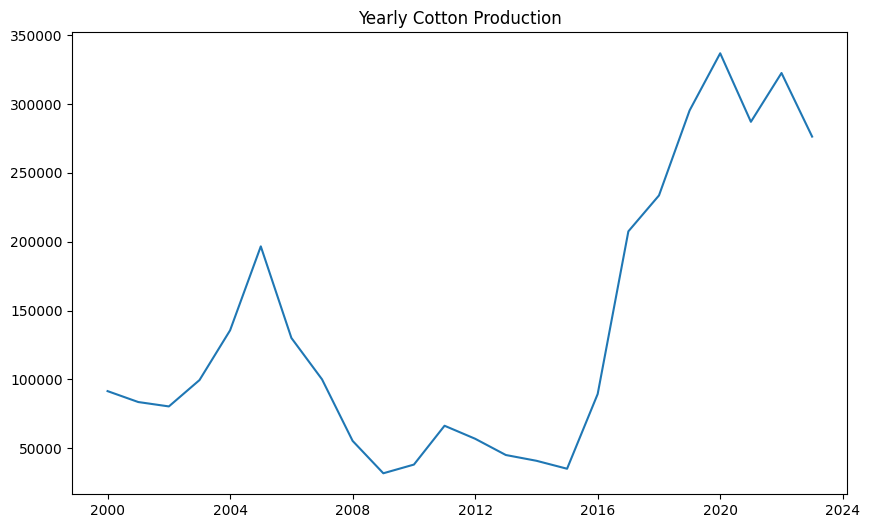

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_production['ds'], yearly_production['y'])
plt.title("Yearly Cotton Production")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the dataset and aggregate production by year
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)

# Prophet Model
# Step 1: Prepare the data for Prophet
data['Year'] = pd.to_datetime(data['Year'], format='%Y')  # Convert to datetime format
yearly_production = data.groupby('Year')['Production'].sum().reset_index()
yearly_production.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

# Step 2: Train-test split for Prophet
train_size = int(len(yearly_production) * 0.8)
train_prophet = yearly_production[:train_size]
test_prophet = yearly_production[train_size:]

# Step 3: Train Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Step 4: Forecast future production
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='Y')  # Forecast for future years
forecast = prophet_model.predict(future)

# Prophet performance metrics
predicted_prophet = forecast['yhat'][-len(test_prophet):].values
actual_prophet = test_prophet['y'].values

mse_prophet = mean_squared_error(actual_prophet, predicted_prophet)
mae_prophet = mean_absolute_error(actual_prophet, predicted_prophet)
rmse_prophet = np.sqrt(mse_prophet)
r2_prophet = r2_score(actual_prophet, predicted_prophet)

# Print Prophet performance metrics
print(f'Prophet Model Mean Squared Error (MSE): {mse_prophet}')
print(f'Prophet Model Mean Absolute Error (MAE): {mae_prophet}')
print(f'Prophet Model Root Mean Squared Error (RMSE): {rmse_prophet}')
print(f'Prophet Model R-squared (R²): {r2_prophet}')

# Plot Prophet predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.legend()
plt.title('Prophet - Actual vs Predicted Cotton Production')
plt.show()

# LSTM Model
# Step 1: Aggregate production per year for LSTM
yearly_production_lstm = data.groupby('Year')['Production'].sum().values.reshape(-1, 1)

# Step 2: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_production = scaler.fit_transform(yearly_production_lstm)

# Step 3: Train-test split for LSTM
train_size_lstm = int(len(scaled_production) * 0.8)
train_lstm, test_lstm = scaled_production[:train_size_lstm], scaled_production[train_size_lstm:]

# Step 4: Prepare the data for LSTM
def create_dataset(dataset, look_back=3):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X_train, y_train = create_dataset(train_lstm, look_back)
X_test, y_test = create_dataset(test_lstm, look_back)

# Step 5: Reshape input for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 6: Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Step 8: Make predictions with LSTM
train_predict_lstm = model.predict(X_train)
test_predict_lstm = model.predict(X_test)

# Step 9: Inverse transform predictions and actual values
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# LSTM performance metrics
mse_lstm = mean_squared_error(y_test[0], test_predict_lstm)
mae_lstm = mean_absolute_error(y_test[0], test_predict_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test[0], test_predict_lstm)

# Print LSTM performance metrics
print(f'LSTM Model Mean Squared Error (MSE): {mse_lstm}')
print(f'LSTM Model Mean Absolute Error (MAE): {mae_lstm}')
print(f'LSTM Model Root Mean Squared Error (RMSE): {rmse_lstm}')
print(f'LSTM Model R-squared (R²): {r2_lstm}')

# Plot LSTM predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(look_back, len(train_predict_lstm) + look_back), train_predict_lstm, label="Train Predictions", color='orange')
plt.plot(np.arange(len(train_predict_lstm) + 2 * look_back, len(train_predict_lstm) + 2 * look_back + len(test_predict_lstm)), test_predict_lstm, label="Test Predictions", color='green')
plt.legend()
plt.title("LSTM - Actual vs Predicted Cotton Production")
plt.show()

# Compare Prophet vs LSTM performance
print("\nComparison of Prophet and LSTM:")
print(f"Prophet MSE: {mse_prophet}, LSTM MSE: {mse_lstm}")
print(f"Prophet MAE: {mae_prophet}, LSTM MAE: {mae_lstm}")
print(f"Prophet RMSE: {rmse_prophet}, LSTM RMSE: {rmse_lstm}")
print(f"Prophet R²: {r2_prophet}, LSTM R²: {r2_lstm}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from statsmodels.tsa.forecasting.theta import ThetaModel

# Load the dataset
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)
yearly_production = data.groupby('Year')['Production'].sum().reset_index()
X = yearly_production['Year'].values.reshape(-1, 1)
y = yearly_production['Production'].values

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Store all results
model_results = {}

# === 1. ARIMA ===
arima_model = ARIMA(y_train, order=(5, 1, 0)).fit()
arima_forecast = arima_model.forecast(steps=len(y_test))
mse_arima = mean_squared_error(y_test, arima_forecast)
mae_arima = mean_absolute_error(y_test, arima_forecast)
model_results['ARIMA'] = (mse_arima, mae_arima)

# === 2. SARIMA ===
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.forecast(steps=len(y_test))
mse_sarima = mean_squared_error(y_test, sarima_forecast)
mae_sarima = mean_absolute_error(y_test, sarima_forecast)
model_results['SARIMA'] = (mse_sarima, mae_sarima)

# === 3. ETS ===
ets_model = ExponentialSmoothing(y_train, trend="add", seasonal=None).fit()
ets_forecast = ets_model.forecast(steps=len(y_test))
mse_ets = mean_squared_error(y_test, ets_forecast)
mae_ets = mean_absolute_error(y_test, ets_forecast)
model_results['ETS'] = (mse_ets, mae_ets)

# === 4. Holt-Winters ===
hw_model = ExponentialSmoothing(y_train, trend='add', seasonal=None).fit()
hw_forecast = hw_model.forecast(steps=len(y_test))
mse_hw = mean_squared_error(y_test, hw_forecast)
mae_hw = mean_absolute_error(y_test, hw_forecast)
model_results['Holt-Winters'] = (mse_hw, mae_hw)

# === 5. Random Forest ===
rf_model = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, rf_forecast)
mae_rf = mean_absolute_error(y_test, rf_forecast)
model_results['Random Forest'] = (mse_rf, mae_rf)

# === 6. XGBoost ===
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100).fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_forecast)
mae_xgb = mean_absolute_error(y_test, xgb_forecast)
model_results['XGBoost'] = (mse_xgb, mae_xgb)

# === 7. SVR ===
svr_model = SVR(kernel='rbf').fit(X_train, y_train)
svr_forecast = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, svr_forecast)
mae_svr = mean_absolute_error(y_test, svr_forecast)
model_results['SVR'] = (mse_svr, mae_svr)

# === 8. LSTM ===
# === 8. LSTM (Updated) ===
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

look_back = 3
def create_lstm_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Create LSTM datasets
X_lstm, y_lstm = create_lstm_dataset(y_scaled, look_back)

# Adjust train/test split based on LSTM reshaped data
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Reshape the input for LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0)

# Predict using LSTM model
lstm_forecast = lstm_model.predict(X_test_lstm)

# Inverse transform the scaled predictions
lstm_forecast = scaler.inverse_transform(lstm_forecast)
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate performance metrics
mse_lstm = mean_squared_error(y_test_lstm_actual, lstm_forecast)
mae_lstm = mean_absolute_error(y_test_lstm_actual, lstm_forecast)
model_results['LSTM'] = (mse_lstm, mae_lstm)

# === 9. CNN ===
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0)
cnn_forecast = cnn_model.predict(X_test_lstm)
cnn_forecast = scaler.inverse_transform(cnn_forecast)
mse_cnn = mean_squared_error(y_test[look_back:], cnn_forecast)
mae_cnn = mean_absolute_error(y_test[look_back:], cnn_forecast)
model_results['CNN'] = (mse_cnn, mae_cnn)

# === 10. Prophet ===
prophet_data = yearly_production.rename(columns={'Year': 'ds', 'Production': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='Y')
forecast = prophet_model.predict(future)
prophet_forecast = forecast['yhat'].values[-len(y_test):]
mse_prophet = mean_squared_error(y_test, prophet_forecast)
mae_prophet = mean_absolute_error(y_test, prophet_forecast)
model_results['Prophet'] = (mse_prophet, mae_prophet)

# === 11. Theta Model ===
theta_model = ThetaModel(y_train).fit()
theta_forecast = theta_model.forecast(len(y_test))
mse_theta = mean_squared_error(y_test, theta_forecast)
mae_theta = mean_absolute_error(y_test, theta_forecast)
model_results['Theta'] = (mse_theta, mae_theta)

# === Performance Comparison Plot ===
models = list(model_results.keys())
mse_vals = [model_results[model][0] for model in models]
mae_vals = [model_results[model][1] for model in models]

# MSE Plot
plt.figure(figsize=(12, 6))
plt.bar(models, mse_vals, color='lightblue')
plt.xticks(rotation=45)
plt.title('MSE Comparison of Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# MAE Plot
plt.figure(figsize=(12, 6))
plt.bar(models, mae_vals, color='orange')
plt.xticks(rotation=45)
plt.title('MAE Comparison of Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt

# Print all the results
for model, (mse, mae) in model_results.items():
    print(f"{model} -> MSE: {mse}, MAE: {mae}")


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)
yearly_production = data.groupby('Year')['Production'].sum().values.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(yearly_production)

# Create dataset with look-back
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Split the dataset into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to fit CNN-LSTM input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate performance metrics
mse = mean_squared_error(y_test[0], test_predict)
mae = mean_absolute_error(y_test[0], test_predict)
rmse = np.sqrt(mse)

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_predict)), train_predict, label="Train Predictions", color='blue')
plt.plot(range(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label="Test Predictions", color='green')
plt.plot(range(len(yearly_production)), yearly_production, label="Actual Values", color='orange')
plt.legend()
plt.title('CNN-LSTM Cotton Production Forecast')
plt.show()

# Print the performance metrics
print(f'CNN-LSTM Model MSE: {mse}')
print(f'CNN-LSTM Model MAE: {mae}')
print(f'CNN-LSTM Model RMSE: {rmse}')


/Users/ismatsamadov/Cotton_Production_Forecasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-13 05:58:54,609] A new study created in memory with name: no-name-174828e5-bc90-42c4-b3c7-b6c03e84c4cf
[I 2024-10-13 05:58:54,635] Trial 0 finished with value: 10978518587.92419 and parameters: {'p': 3, 'd': 2, 'q': 0}. Best is trial 0 with value: 10978518587.92419.
[I 2024-10-13 05:58:54,644] Trial 1 finished with value: 2378506547.792468 and parameters: {'p': 4, 'd': 1, 'q': 0}. Best is trial 1 with value: 2378506547.792468.
[I 2024-10-13 05:58:54,650] Trial 2 finished with value: 1843281220.4153626 and parameters: {'p': 0, 'd': 1, 'q': 1}. Best is trial 2 with value: 1843281220.4153626.
[I 2024-10-13 05:58:54,656] Trial 3 finished with value: 4302084850.757775 and parameters: {'p': 1, 'd

Best ARIMA parameters: {'p': 4, 'd': 2, 'q': 4}


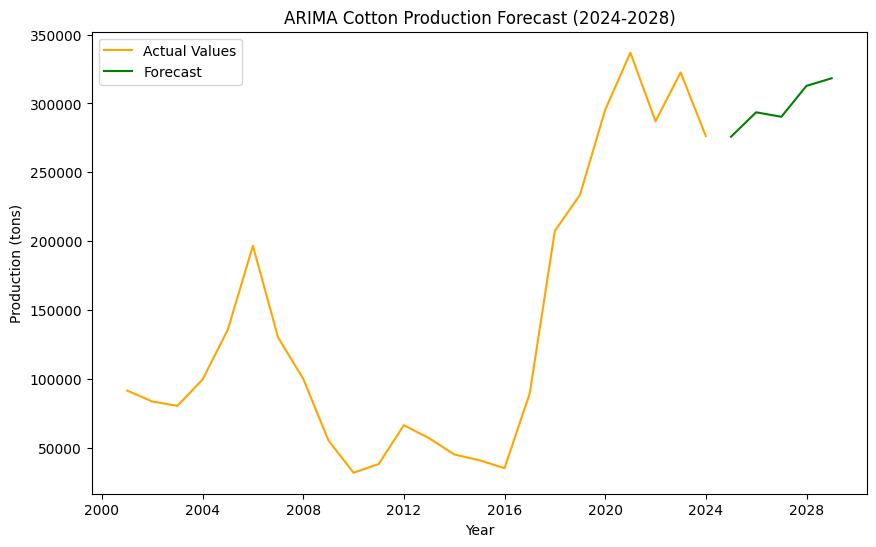

Scaler saved successfully.
Look back value saved successfully.
ARIMA model saved successfully.
Forecast values saved successfully.
Forecast for the next years: 2024-12-31    275822.375054
2025-12-31    293555.542919
2026-12-31    290282.240720
2027-12-31    312717.211612
2028-12-31    318252.053162
Freq: YE-DEC, Name: predicted_mean, dtype: float64


In [1]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = 'transformed_cotton_production.csv'
data = pd.read_csv(file_path)

# Use only Year and Production columns, summing production by Year
yearly_production = data.groupby('Year')['Production'].sum()

# Create a time series index
yearly_production.index = pd.date_range(start='2000', periods=len(yearly_production), freq='YE')

# Define look_back (set this value based on your requirement)
look_back = 5  # Example value; adjust as needed

# Create a function to evaluate the ARIMA model
def evaluate_arima(order):
    try:
        # Only use data up to the present for training
        train_data = yearly_production[:'2023']  # Up to 2023
        
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        # Generate predictions for the next 5 years
        forecast = model_fit.forecast(steps=5)  # Forecasting for 2024-2028
        return mean_squared_error(train_data[-5:], forecast)
    except Exception as e:
        print(f"Error in model fitting: {e}")
        return np.inf  # Return a large number to indicate failure

# Define the Optuna objective function for ARIMA
def objective(trial):
    p = trial.suggest_int('p', 0, 5)  # AR term
    d = trial.suggest_int('d', 0, 2)  # Differencing
    q = trial.suggest_int('q', 0, 5)  # MA term
    
    order = (p, d, q)
    return evaluate_arima(order)

# Create an Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best ARIMA parameters: {best_params}")

# Train the final model with the best hyperparameters using past data up to 2023
final_model = ARIMA(yearly_production[:'2023'], order=(best_params['p'], best_params['d'], best_params['q']))
final_model_fit = final_model.fit()

# Generate future predictions for 2024-2028
forecast = final_model_fit.forecast(steps=5)  # Forecasting for the next 5 years

# Create a date range for the forecast
future_years = pd.date_range(start=yearly_production.index[-1], periods=6, freq='Y')[1:]

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(yearly_production.index, yearly_production.values, label="Actual Values", color='orange')
plt.plot(future_years, forecast, label="Forecast", color='green')
plt.legend()
plt.title('ARIMA Cotton Production Forecast (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Production (tons)')
plt.show()

# Scaling: Create and save the scaler for future use
scaler = MinMaxScaler()

# Fit your scaler on the production data
scaler.fit(data[['Production']])

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved successfully.")

# Save the look_back variable
joblib.dump(look_back, 'look_back.pkl')
print("Look back value saved successfully.")

# Save the trained ARIMA model
joblib.dump(final_model_fit, 'arima_model.pkl')
print("ARIMA model saved successfully.")

# Optionally, save the forecast values for future reference
forecast_df = pd.DataFrame(forecast, index=future_years, columns=['Forecast'])
forecast_df.to_csv('forecasted_cotton_production.csv')
print("Forecast values saved successfully.")

# Print performance metrics
print(f'Forecast for the next years: {forecast}')
